# Class Challenge: Image Classification of COVID-19 X-rays
# Task 1 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Binary Classification: COVID-19 vs. Normal

In [2]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# os.environ['OMP_NUM_THREADS'] = '1'
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

tf.__version__

'2.1.0'

In [3]:
# # https://www.tensorflow.org/guide/gpu
# tf.debugging.set_log_device_placement(True)
# # Create some tensors
# a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
# b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
# c = tf.matmul(a, b)

# # https://stackoverflow.com/questions/38559755/how-to-get-current-available-gpus-in-tensorflow
# from tensorflow.python.client import device_lib

# def get_available_gpus():
#     local_device_protos = device_lib.list_local_devices()
#     return [x.name for x in local_device_protos if x.device_type == 'GPU']
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# get_available_gpus()


#### Load Image Data

In [4]:
DATA_LIST = os.listdir('two/train')
DATASET_PATH  = 'two/train'
TEST_DIR =  'two/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 40 #40
LEARNING_RATE = 0.0005 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="binary")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",seed=42,
                                                  class_mode="binary")




/share/pkg.7/tensorflow/2.1.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout


#pre-trained model with imagenet weights  
vgg_16 = VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))


# fine-tune last conv2D layer
vgg_16.trainable = True
fine_tune = len(vgg_16.layers)-2
print(fine_tune)
for layer in vgg_16.layers[:fine_tune]:
    layer.trainable = False

    

covid_model = Sequential()
covid_model.add(vgg_16)
#covid_model.add(Dropout(0.5))
covid_model.add(Flatten())
covid_model.add(Dropout(0.5))
covid_model.add(Dense(256,activation="relu",name="dense_feature"))
covid_model.add(Dropout(0.5))
covid_model.add(Dense(1,activation="sigmoid"))

covid_model.summary()


17
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_feature (Dense)        (None, 256)               6422784   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 8,782,849
Non-trainable params: 12,354,880
_______________________________

#### [5 points] Train Model

In [7]:
import time

#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

# learning rate schedule 
lrs = tf.keras.optimizers.schedules.InverseTimeDecay(
          LEARNING_RATE,
          decay_steps=STEP_SIZE_TRAIN*10,
          decay_rate=1,
          staircase=False)

opt = tf.keras.optimizers.Adam(lrs)

covid_model.compile(optimizer=opt,
                    loss="binary_crossentropy",    
                    metrics=['accuracy'])

start = time.time()
history = covid_model.fit(train_batches, 
                          steps_per_epoch=STEP_SIZE_TRAIN, 
                          epochs=NUM_EPOCHS, 
                          validation_data=valid_batches, 
                          validation_steps=STEP_SIZE_VALID)
end = time.time()
print("Execution time:",end-start)

11
3


/share/pkg.7/tensorflow/2.1.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/share/pkg.7/tensorflow/2.1.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 2 steps
Epoch 1/40


/share/pkg.7/tensorflow/2.1.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/share/pkg.7/tensorflow/2.1.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


10/10 [==============================] - 7s 653ms/step - loss: 1.8713 - accuracy: 0.4894 - val_loss: 0.4290 - val_accuracy: 0.8000
Epoch 2/40
10/10 [==============================] - 4s 379ms/step - loss: 0.4444 - accuracy: 0.7872 - val_loss: 0.1924 - val_accuracy: 0.9500
Epoch 3/40
10/10 [==============================] - 4s 376ms/step - loss: 0.2535 - accuracy: 0.8830 - val_loss: 0.0674 - val_accuracy: 1.0000
Epoch 4/40
10/10 [==============================] - 4s 368ms/step - loss: 0.2627 - accuracy: 0.9043 - val_loss: 0.1460 - val_accuracy: 0.9000
Epoch 5/40
10/10 [==============================] - 4s 368ms/step - loss: 0.2297 - accuracy: 0.8936 - val_loss: 0.2225 - val_accuracy: 0.9000
Epoch 6/40
10/10 [==============================] - 4s 362ms/step - loss: 0.2995 - accuracy: 0.8617 - val_loss: 0.1643 - val_accuracy: 0.9500
Epoch 7/40
10/10 [==============================] - 4s 356ms/step - loss: 0.3428 - accuracy: 0.8936 - val_loss: 0.1197 - val_accuracy: 0.9500
Epoch 8/40
10/10 

#### [5 points] Plot Accuracy and Loss During Training

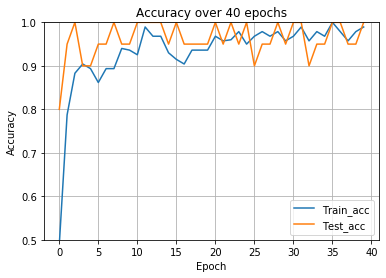

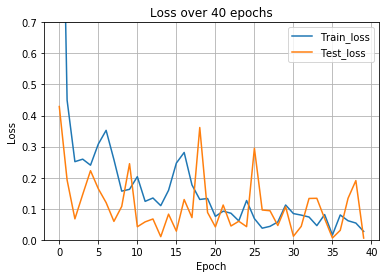

In [8]:
import matplotlib.pyplot as plt

#accuracy vs. epochs plot
plt.figure(1)
plt.plot(history.history['accuracy'], label='Train_acc')
plt.plot(history.history['val_accuracy'], label = 'Test_acc')
plt.title("Accuracy over 40 epochs")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.grid()

#loss vs. epochs plot
plt.figure(2)
plt.plot(history.history['loss'], label='Train_loss')
plt.plot(history.history['val_loss'], label = 'Test_loss')
plt.title("Loss over 40 epochs")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 0.7])
plt.legend(loc='upper right')
plt.grid()

plt.show()

#### Plot Test Results

Found 18 images belonging to 2 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
18/18 [==============================] - 1s 71ms/step - loss: 0.0104 - accuracy: 1.0000
Instructions for updating:
Please use Model.predict, which supports generators.
18/18 [==============================] - 1s 40ms/step
covid/nejmoa2001191_f3-PA.jpeg


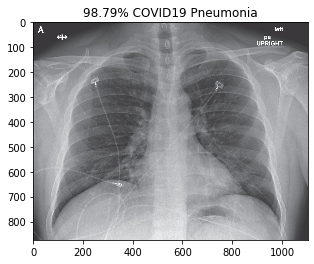

covid/nejmoa2001191_f4.jpeg


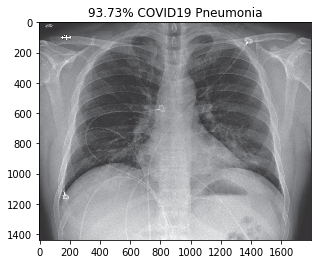

covid/nejmoa2001191_f5-PA.jpeg


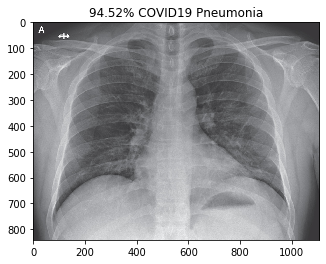

covid/radiol.2020200490.fig3.jpeg


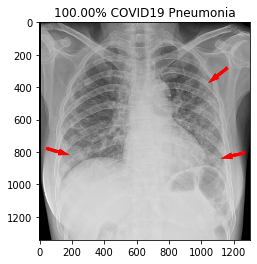

covid/ryct.2020200028.fig1a.jpeg


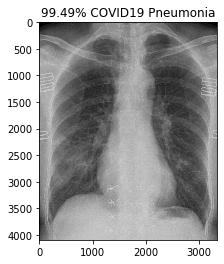

covid/ryct.2020200034.fig2.jpeg


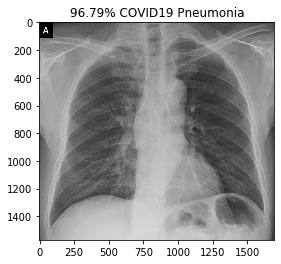

covid/ryct.2020200034.fig5-day0.jpeg


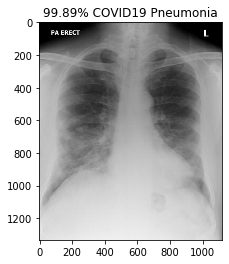

covid/ryct.2020200034.fig5-day4.jpeg


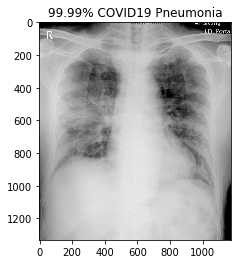

covid/ryct.2020200034.fig5-day7.jpeg


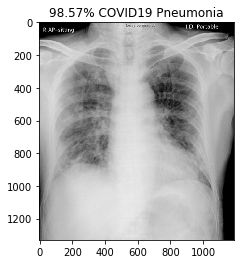

normal/NORMAL2-IM-1385-0001.jpeg


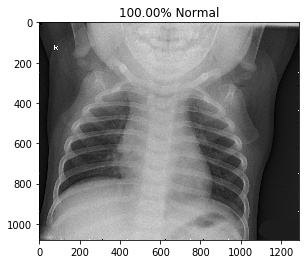

normal/NORMAL2-IM-1396-0001.jpeg


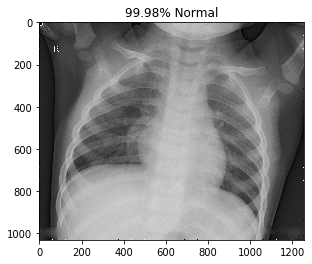

normal/NORMAL2-IM-1400-0001.jpeg


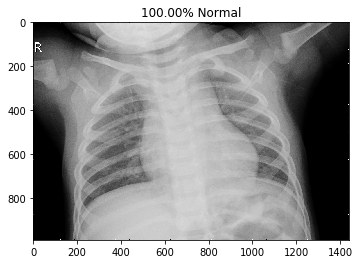

normal/NORMAL2-IM-1401-0001.jpeg


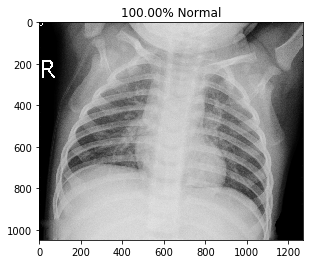

normal/NORMAL2-IM-1406-0001.jpeg


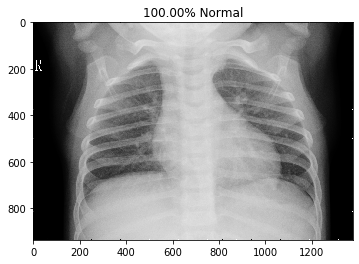

normal/NORMAL2-IM-1412-0001.jpeg


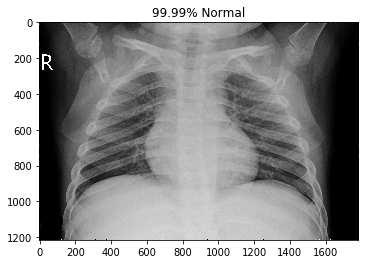

normal/NORMAL2-IM-1419-0001.jpeg


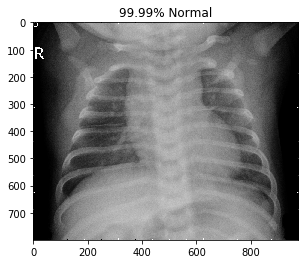

normal/NORMAL2-IM-1422-0001.jpeg


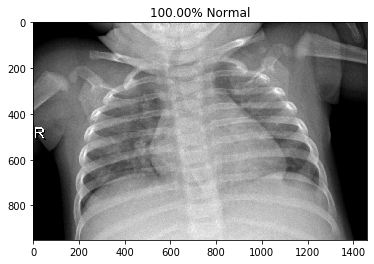

normal/NORMAL2-IM-1423-0001.jpeg


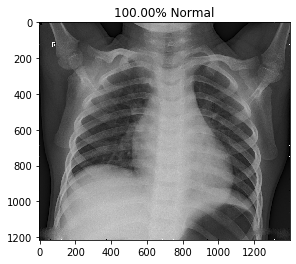

In [9]:
import matplotlib.image as mpimg
model = covid_model
test_datagen = ImageDataGenerator(rescale=1. / 255)
eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="binary")
#print(eval_generator.class_indices)
p = model.evaluate_generator(eval_generator,18,verbose=1)


eval_generator.reset()
pred = model.predict_generator(eval_generator,18,verbose=1)

for index, probability in enumerate(pred):
    image_path = TEST_DIR + "/" +eval_generator.filenames[index]
    image = mpimg.imread(image_path)
    if image.ndim < 3:
        image = np.reshape(image,(image.shape[0],image.shape[1],1))
        image = np.concatenate([image, image, image], 2)
#         print(image.shape)

    pixels = np.array(image)
    plt.imshow(pixels)
    
    print(eval_generator.filenames[index])
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Normal")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% COVID19 Pneumonia")
    plt.show()

## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

Found 130 images belonging to 2 classes.


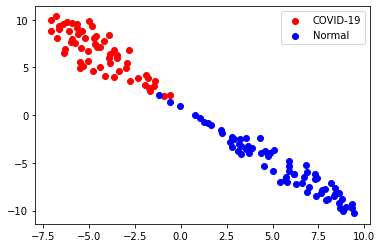

In [10]:
from sklearn.manifold import TSNE
from tensorflow.keras import models

intermediate_layer_model = models.Model(inputs=model.input,
                                        outputs=model.get_layer('dense_feature').output)
tsne_data_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="binary")
#print(tsne_data_generator.class_indices)
labels = tsne_data_generator.labels

predict = intermediate_layer_model.predict_generator(tsne_data_generator)

tsne = TSNE(n_components=2).fit_transform(predict)
covid = []
normal = []
for i in range(len(labels)):
    if labels[i]==0:
        covid.append(tsne[i])
    else:
        normal.append(tsne[i])
        
covid = np.asarray(covid)
normal = np.asarray(normal)

plt.scatter(covid[:,0],covid[:,1],c="r",label="COVID-19")
plt.scatter(normal[:,0],normal[:,1],c="b",label="Normal")
plt.legend(loc='upper right')
plt.show()

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->